In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:22<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# from google.colab import drive
# drive.mount('/content/drive')
import os
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/._chest_xray
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/._test
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/._train
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/._.DS_Store
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/train/._.DS_Store
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/train/._NORMAL
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/train/._PNEUMONIA
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/__MACOSX/chest_xray/train/NORMAL/._I

In [4]:
# labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150
# def get_training_data(data_dir):
#     data = []
#     for label in labels:
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                 resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
#                 data.append([resized_arr, class_num])
#             except Exception as e:
#                 print(e)
#     return np.array(data)

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            # Skip hidden macOS system files
            if img.startswith("._"):
                continue
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                # Check if the image was loaded successfully and has valid dimensions
                if img_arr is not None and img_arr.size > 0:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    data.append([resized_arr, class_num])
                else:
                    print(f"Failed to load or invalid image: {img_path}")
            except Exception as e:
                print(e)
    # Specify dtype=object to handle inhomogeneous shapes
    return np.array(data, dtype=object)

In [6]:
train_path = os.path.join(path, "chest_xray", "train")
test_path = os.path.join(path, "chest_xray", "test")    # Adjust path to your dataset structure
val_path = os.path.join(path, "chest_xray", "val")


In [7]:
train = get_training_data(train_path)
test = get_training_data(test_path)
val = get_training_data(val_path)

In [42]:
print(train.shape)
print(test.shape)
print(val.shape)


(5216, 2)
(624, 2)
(16, 2)


<Axes: xlabel='count'>

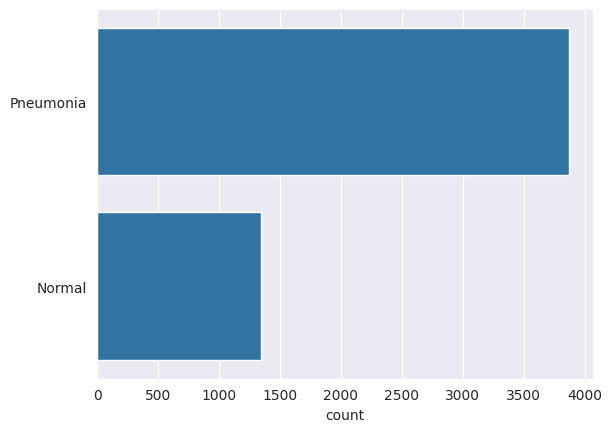

In [8]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

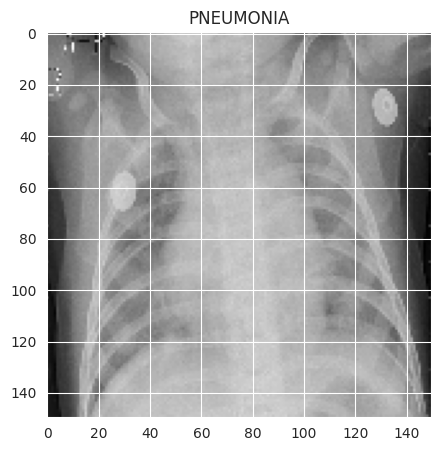

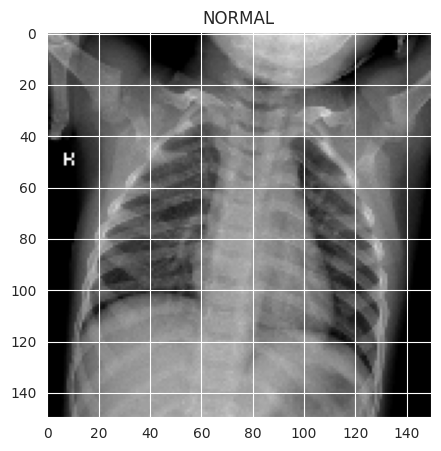

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [10]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [11]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [12]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [28]:

model = Sequential([
    Conv2D(32, (3,3), strides = 1, padding = 'same', activation='relu', input_shape=(150,150,1)),  
    BatchNormalization(),
    MaxPool2D((2,2), strides = 2 , padding = 'same'),

    Conv2D(64, (3,3), strides = 1 , padding = 'same', activation='relu'),  
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), strides = 2 , padding = 'same'),

    Conv2D(64, (3,3), strides = 1 , padding = 'same', activation='relu'),  
    BatchNormalization(),
    MaxPool2D((2,2), strides = 2 , padding = 'same'),

    Conv2D(128, (3,3), strides = 1 , padding = 'same', activation='relu'),  
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), strides = 2 , padding = 'same'),

    Conv2D(256, (3,3), strides = 1 , padding = 'same', activation='relu'),  
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), strides = 2 , padding = 'same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [30]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.7771 - loss: 1.4780 - val_accuracy: 0.5000 - val_loss: 17.9236 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8927 - loss: 0.2643 - val_accuracy: 0.5000 - val_loss: 59.8457 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9169 - loss: 0.2284
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9169 - loss: 0.2284 - val_accuracy: 0.5000 - val_loss: 33.4619 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9496 - loss: 0.1459 - val_accuracy: 0.5625 - val_loss: 5.4717 - learning_rate: 3.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9510 - loss: 0.1333 - val_accuracy: 0.5000 - val_loss: 24.3798 - learning_rate: 3.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9507 - lo

In [31]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9214 - loss: 0.2623
Loss of the model is -  0.3067077398300171
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9214 - loss: 0.2623
Accuracy of the model is -  91.18589758872986 %


In [40]:
model.evaluate(x_test,y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9214 - loss: 0.2623


[0.3067077398300171, 0.9118589758872986]

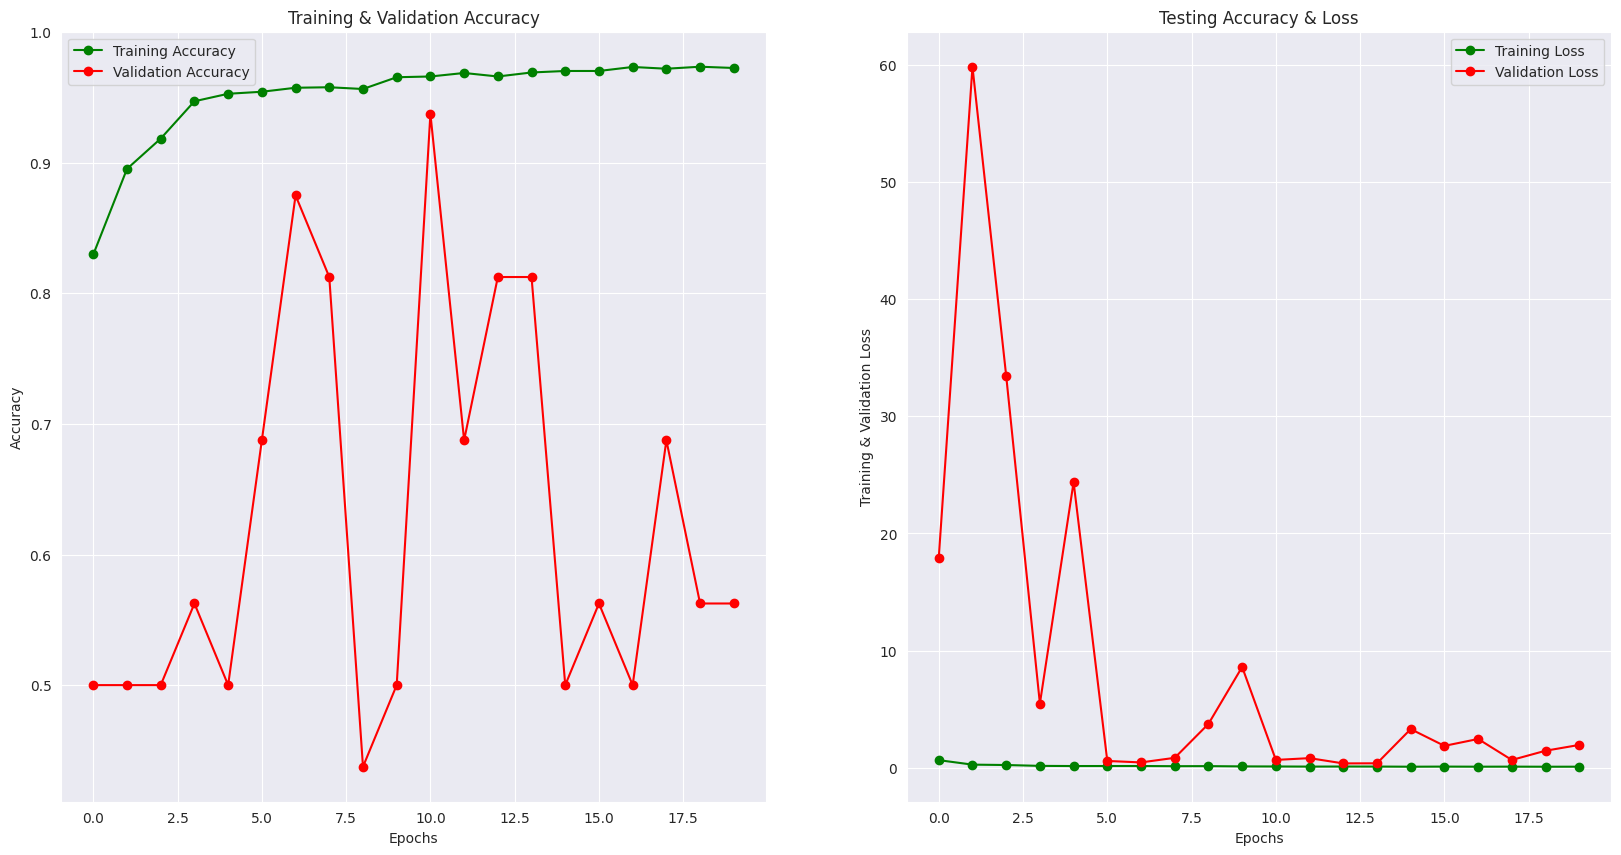

In [32]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [33]:
# !pip install torchmetrics

import torch
from torchmetrics import ConfusionMatrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, x_test, y_test):
    """
    Evaluates the model's performance using various metrics.

    Args:
    model: The trained Keras model.
    x_test: The test data.
    y_test: The true labels for the test data.
    """
    # Get model predictions (change threshold if necessary)
    predictions = (model.predict(x_test) > 0.5).astype("int32")
    predictions = predictions.reshape(1,-1)[0]

    # Calculate metrics
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    print(f'Test Accuracy: {model.evaluate(x_test,y_test)[1]*100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    print('Confusion Matrix:')
    print(cm)

# Call evaluate_model directly
evaluate_model(model, x_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9214 - loss: 0.2623
Test Accuracy: 91.19%
Precision: 0.8776
Recall: 0.8889
F1-score: 0.8832
AUC: 0.9073
Confusion Matrix:
[[361  29]
 [ 26 208]]


In [34]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0] # Reshape to a 1D array if necessary
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.93      0.93       390
   Normal (Class 1)       0.88      0.89      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.91      0.91       624



In [35]:
cm = confusion_matrix(y_test,predictions)
cm

array([[361,  29],
       [ 26, 208]])

In [36]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

Confusion Matrix:


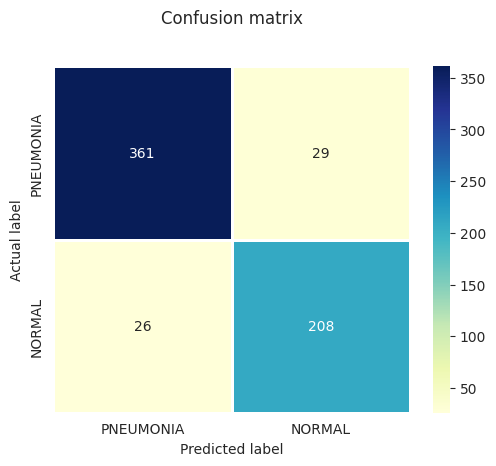

In [47]:
plt.figure(figsize = (5,4))
sns.heatmap(cm, linewidth = 1 , annot = True, cmap="YlGnBu" ,fmt='g',xticklabels = labels,yticklabels = labels)
    # sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion Matrix:")

In [37]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]